# lnc mRNA Filtering

One of the main features of transcription is **alternative splicing (AS)**. This process allows one gene to produce differents mRNA products by modulating the AS machinery. Each unique alternative transcript is called an **isoform**, every gene can have one or more isoforms with different characteristics. Different isoforms can code for different proteins, commonly alternative isoforms have **premature stop codons (PTCs)** that funnel the transcripts to the degradation machinery (**NMD**). In this work we propose a **new function for mRNAs**, some isoforms never reach the ribosomes for translation and also are not degraded, making them an stable molecule that acummulates in the cell. We belive this isoforms have a role as lnc-mRNAs, mainly in the nucleus. This script is intended to filter out isoforms taking into account all the above mentiones characteristics, leaving us with a small group of lnc-mRNA isoforms for further studies.

lnc RNAs will be filtered by two main features: Stable RNAs (not degraded) and not translated. Four datasets are used in this script:
- Polyribosomes: https://doi.org/10.1111/tpj.12502
- NMD deficient(Cicloheximide and upf1 & upf3 mutants): https://doi.org/10.1105/tpc.113.115485 
- Own ONT data (Total, Nuclear, Citoplasmatic)
- Own illumina data (Total, Nuclear, Citoplasmatic)

**Objectives:**
- Define a universe of isoforms (total isoforms present in the model studied)
- Remove the isoforms that are being translated (polyribosomes)
- Remove the isoforms that are being degraded (NMD deficient)
    - To achieve this, isoforms that increase their presence on NMD deficient samples, are considered NMD sensitive
- Keep the nuclear isoforms (and discard the citoplasmatic)
- Asses light/Dark changes.
- Quantify the proportion in nucleus/citoplasm of this isoforms

*For this analisys I used a modified version of "AtRTD2_QUASI", called "AtRTD2.1_QUASI". This version was done by filtering out low expressed isoforms from 155 datasets quantified by SALMON using the "AtRTD2_QUASI" transcriptome (this datasets include illumina and ONT data).*


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils import concatenate_files_exclude

IndentationError: expected an indented block after function definition on line 4 (utils.py, line 5)

In [2]:
import empias

Package loaded correctly...


## Load data

In [3]:
file_dir = "/home/lucas-elytron/Documents/paper_doct/Nuc_cito/mapping/salmon/AtRTDv2_1_QUASI"
transcriptome = pd.read_parquet("/home/lucas-elytron/Documents/paper_doct/Nuc_cito/mapping/reference/mod_refs/AtRTDv2_1_QUASI.LS.parquet")

In [4]:
transcriptome.to_csv("./AtRTDv2_1.csv", index=False)

### Illumina

In [4]:
illumina_data, illumina_files = concatenate_files_exclude(file_dir, transcriptome, "ONT",)
illumina_data = illumina_data.rename(columns={"Name":"isoform"})
grouped = illumina_data.groupby('df_name')
illu_dfs, illu_dfs_names  = {x : grouped.get_group(x) for x in grouped.groups}, [x for x in grouped.groups]
#Check
illu_dfs[illu_dfs_names[0]].head()

index  Length  EffectiveLength        TPM  NumReads  \
gene      isoform                                                             
AT1G01010 AT1G01010.1       0    1688            100.0   2.759793     2.000   
AT1G01020 AT1G01020_P1      1    1329            100.0  31.251582    22.648   
          AT1G01020_P2      2    1480            100.0   9.330350     6.762   
          AT1G01020_P3      3    1420            100.0  69.809793    50.591   
          AT1G01020_P4      4    1397            100.0   0.000000     0.000   

                                                                  df_name  
gene      isoform                                                          
AT1G01010 AT1G01010.1   282e9e6d3ce583adb2727344a030c7f973a8b8ac_SQK-P...  
AT1G01020 AT1G01020_P1  282e9e6d3ce583adb2727344a030c7f973a8b8ac_SQK-P...  
          AT1G01020_P2  282e9e6d3ce583adb2727344a030c7f973a8b8ac_SQK-P...  
          AT1G01020_P3  282e9e6d3ce583adb2727344a030c7f973a8b8ac_SQK-P...  
          AT1G01020_P4  282e9e6d3ce583adb2727344a030c7f973a8b8ac_SQK-P...

In [6]:
#Polyribosomes fraction
illu_polyribosomes = pd.concat([illu_dfs["ERR377676"].TPM ,illu_dfs["ERR377677"].TPM ,illu_dfs["ERR377678"].TPM], axis=1, keys=[("Polyribosomes","TPM_1"),("Polyribosomes","TPM_2"),("Polyribosomes","TPM_3")])
#NMD conditions
illu_nmd_keys = [("Chx","TPM_1"),("Chx","TPM_2"),
                 ("Mock","TPM_1"),("Mock","TPM_2"),
                 ("upf1upf3","TPM_1"),("upf1upf3","TPM_2"),
                 ("upf1","TPM_1"),("upf1","TPM_2"),
                 ("upf3","TPM_1"),("upf3","TPM_2"),
                 ("wt","TPM_1"),("wt","TPM_2"),]
illu_nmd = pd.concat([illu_dfs[x].TPM for x in illu_dfs_names[3:-6]], axis=1, keys=illu_nmd_keys)
# Celullar localization (illumina)
illu_tot_nuc_cito_keys = [("Total L","TPM_1"),("Total D","TPM_1"),
                          ("Nuc L","TPM_1"),("Nuc D","TPM_1"),
                          ("Cit L","TPM_1"),("Cit D","TPM_1"),]
illu_tot_nuc_cito = pd.concat([illu_dfs[x].TPM for x in illu_dfs_names[-6:]], axis=1, keys=illu_tot_nuc_cito_keys)

#Check
illu_tot_nuc_cito.head()

Total L    Total D      Nuc L      Nuc D     Cit L  \
                            TPM_1      TPM_1      TPM_1      TPM_1     TPM_1   
gene      isoform                                                              
AT1G01010 AT1G01010.1    9.920503  22.895853  12.240711  14.693500  6.754882   
AT1G01020 AT1G01020_P1  10.589541   9.635289  33.751283  28.672398  5.629857   
          AT1G01020_P2   0.059667   0.058922   1.293679   0.667937  0.000000   
          AT1G01020_P3   1.196947   3.936884  12.378573  16.577624  0.263974   
          AT1G01020_P4   1.272106   1.100532   5.236000   5.255813  0.000000   

                            Cit D  
                            TPM_1  
gene      isoform                  
AT1G01010 AT1G01010.1   16.177555  
AT1G01020 AT1G01020_P1   7.261125  
          AT1G01020_P2   0.000000  
          AT1G01020_P3   0.183908  
          AT1G01020_P4   0.187789

In [8]:
illu_tot_nuc_cito.loc[["AT5G65050",],:]

Total L    Total D      Nuc L       Nuc D  \
                             TPM_1      TPM_1      TPM_1       TPM_1   
gene      isoform                                                      
AT5G65050 AT5G65050_JS1  24.267221  40.259224  80.961718  132.770709   
          AT5G65050_JS2   7.413352  14.567312  47.088212   83.986369   

                             Cit L      Cit D  
                             TPM_1      TPM_1  
gene      isoform                              
AT5G65050 AT5G65050_JS1  18.357259  28.731535  
          AT5G65050_JS2   2.754373   5.895804

### ONT

In [10]:
ONT_data, ONT_files = concatenate_files_exclude(file_dir+"ONT", transcriptome)

grouped = ONT_data.groupby('df_name')
ont_dfs, ont_dfs_names  = {x : grouped.get_group(x) for x in grouped.groups}, [x for x in grouped.groups]
ont_dfs_names[:-2]
ont_barcode_keys = [("Nuc L","TPM_1"),("Nuc L","TPM_2"),("Nuc L","TPM_3"),
                    ("Nuc D","TPM_1"),("Nuc D","TPM_2"),("Nuc D","TPM_3"),
                    ("Cit L","TPM_1"),("Cit L","TPM_2"),("Cit L","TPM_3"),
                    ("Cit D","TPM_1"),("Cit D","TPM_2"),("Cit D","TPM_3"),]
ONT_nuc_cito = pd.concat([ont_dfs[x].TPM for x in ont_dfs_names[:-2]], axis=1, keys=ont_barcode_keys)
ONT_total = pd.concat([ont_dfs[x].TPM for x in ont_dfs_names[-2:]], axis=1, keys=[("Total D","TPM_1"),("Total L","TPM_1")])
#Check
ONT_total.columns.set_names(["condition", "sample"], inplace=True)
ONT_nuc_cito.columns.set_names(["condition", "sample"], inplace=True)
ONT_nuc_cito.head()

condition                   Nuc L                            Nuc D             \
sample                      TPM_1      TPM_2      TPM_3      TPM_1      TPM_2   
gene      isoform                                                               
AT1G01010 AT1G01010.1    1.527028  10.986741   0.000000   9.393570   6.492840   
AT1G01020 AT1G01020_P1  39.665812  35.736423  32.955794  38.689570  36.219185   
          AT1G01020_P2  16.993132   5.992718   0.000000   0.000000   0.000000   
          AT1G01020_P3  57.868128  61.546227  89.969836  81.548125  61.173421   
          AT1G01020_P4   0.000000   0.000000   0.000000   0.000000   0.000000   

condition                              Cit L                          Cit D  \
sample                      TPM_3      TPM_1     TPM_2      TPM_3     TPM_1   
gene      isoform                                                             
AT1G01010 AT1G01010.1    9.714350   6.642859  8.879477   9.697252  6.692679   
AT1G01020 AT1G01020_P1  31.969493  23.914291  8.879477  19.394504  0.000000   
          AT1G01020_P2   0.000000   0.000000  0.000000   0.000000  6.692679   
          AT1G01020_P3  99.477990   0.000000  0.000000   0.000000  0.000000   
          AT1G01020_P4   0.000000   0.000000  0.000000   0.000000  0.000000   

condition                                     
sample                      TPM_2      TPM_3  
gene      isoform                             
AT1G01010 AT1G01010.1   13.578707  13.641727  
AT1G01020 AT1G01020_P1  12.759575  11.368106  
          AT1G01020_P2   0.000000   0.000000  
          AT1G01020_P3  12.458024   0.000000  
          AT1G01020_P4   0.000000   0.000000

In [11]:
ONT_nuc_cito.loc[["AT5G65050",],:]

condition                     Nuc L                               Nuc D  \
sample                        TPM_1       TPM_2       TPM_3       TPM_1   
gene      isoform                                                         
AT5G65050 AT5G65050_JS1  233.440891  237.082281  213.071098  379.004959   
          AT5G65050_JS2   15.328022    4.626026    0.000000   20.627417   

condition                                            Cit L             \
sample                        TPM_2       TPM_3      TPM_1      TPM_2   
gene      isoform                                                       
AT5G65050 AT5G65050_JS1  376.074254  420.834445  49.169639  33.298037   
          AT5G65050_JS2   13.468850    9.304354   2.644658   0.000000   

condition                               Cit D                        
sample                       TPM_3      TPM_1      TPM_2      TPM_3  
gene      isoform                                                    
AT5G65050 AT5G65050_JS1  38.632988  55.772324  50.435198  63.661394  
          AT5G65050_JS2   5.004645   0.000000   0.000000   0.000000

In [8]:
#ONT_nuc_cito.columns.set_names(["condition", "sample"], inplace=True)
display(ONT_nuc_cito.loc[:,["Nuc L", "Nuc D"]])

condition                    Nuc L                               Nuc D   
sample                       TPM_1       TPM_2       TPM_3       TPM_1   
gene      isoform                                                        
AT1G01010 AT1G01010.1     1.527028   10.986741    0.000000    9.393570  \
AT1G01020 AT1G01020_P1   39.665812   35.736423   32.955794   38.689570   
          AT1G01020_P2   16.993132    5.992718    0.000000    0.000000   
          AT1G01020_P3   57.868128   61.546227   89.969836   81.548125   
          AT1G01020_P4    0.000000    0.000000    0.000000    0.000000   
...                            ...         ...         ...         ...   
ATMG01330 ATMG01330.1     0.000000    0.000000    0.000000    0.000000   
ATMG01350 ATMG01350.1     1.527028    0.000000    0.000000    0.000000   
ATMG01370 ATMG01370.1     3.054055    2.197348    8.195042    0.000000   
ATMG01380 ATMG01380.1     3.054055    6.592045    0.000000    3.757428   
ATMG01390 ATMG01390.1   217.384752  138.432939  139.315714  231.081820   

condition                                       
sample                       TPM_2       TPM_3  
gene      isoform                               
AT1G01010 AT1G01010.1     6.492840    9.714350  
AT1G01020 AT1G01020_P1   36.219185   31.969493  
          AT1G01020_P2    0.000000    0.000000  
          AT1G01020_P3   61.173421   99.477990  
          AT1G01020_P4    0.000000    0.000000  
...                            ...         ...  
ATMG01330 ATMG01330.1     0.000000    0.000000  
ATMG01350 ATMG01350.1     0.000000    0.000000  
ATMG01370 ATMG01370.1     1.298568    0.000000  
ATMG01380 ATMG01380.1     0.000000    2.428587  
ATMG01390 ATMG01390.1   211.666595  238.001564  

[54095 rows x 6 columns]

In [9]:
pval_ONT_nuc_L_O = empias.calculate_empirical_pvalue(ONT_nuc_cito.loc[:,["Nuc L", "Nuc D"]], progress_bar=True)

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
(54095, 2)
(108190, 2)
(162285, 2)
(216380, 2)
(270475, 2)
(324570, 2)


In [10]:
pval_ONT_nuc_L_O.to_csv("./pval_ONT_nuc_L_O.csv")

In [11]:
display(ONT_nuc_cito.loc[:,["Nuc L", "Nuc D"]].head())
pval_ONT_nuc_L_O_filt = pval_ONT_nuc_L_O[pval_ONT_nuc_L_O["pvalues"]< 0.05]
pval_ONT_nuc_L_O_filt.dropna()

condition                   Nuc L                            Nuc D              
sample                      TPM_1      TPM_2      TPM_3      TPM_1      TPM_2   
gene      isoform                                                               
AT1G01010 AT1G01010.1    1.527028  10.986741   0.000000   9.393570   6.492840  \
AT1G01020 AT1G01020_P1  39.665812  35.736423  32.955794  38.689570  36.219185   
          AT1G01020_P2  16.993132   5.992718   0.000000   0.000000   0.000000   
          AT1G01020_P3  57.868128  61.546227  89.969836  81.548125  61.173421   
          AT1G01020_P4   0.000000   0.000000   0.000000   0.000000   0.000000   

condition                          
sample                      TPM_3  
gene      isoform                  
AT1G01010 AT1G01010.1    9.714350  
AT1G01020 AT1G01020_P1  31.969493  
          AT1G01020_P2   0.000000  
          AT1G01020_P3  99.477990  
          AT1G01020_P4   0.000000

,,logFC,tpm_mean,pvalues
gene,isoform,,,
AT1G01010,AT1G01010.1,1.036005,-inf,0.002498
AT1G01030,AT1G01030.1,1.233979,-inf,0.001998
AT1G01050,AT1G01050_c1,-1.392886,6.748700,0.035465
AT1G01070,AT1G01070_P1,-1.899963,3.973313,0.014985
AT1G01080,AT1G01080_JS1,-1.554821,4.904766,0.026474
...,...,...,...,...
ATMG00780,ATMG00780.1,-1.754268,-inf,0.001998
ATMG00970,ATMG00970.1,1.276686,-inf,0.001998
ATMG01060,ATMG01060.1,-2.055231,-inf,0.000999


## Filtering by expression

The Polyribosomes data will be filtered by expression of isoforms, setting a treshold of TPMs.

(42851, 3)
(21000, 3)
(17123, 3)
(14921, 3)


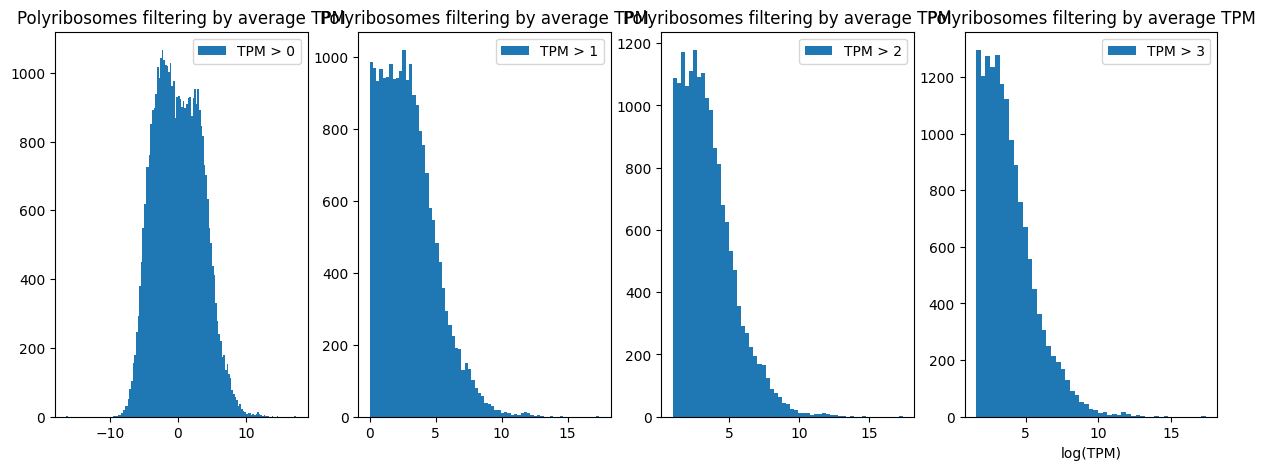

In [12]:
fig, axs = plt.subplots(1,4, figsize=(15,5))
for i in range(4):
    bins_size = int(illu_polyribosomes[illu_polyribosomes.mean(axis=1) > i].shape[0]/300)
    axs[i].hist(np.log2(illu_polyribosomes[illu_polyribosomes.mean(axis=1) > i].mean(axis=1)),bins=bins_size,
                label="TPM > " + str(i))
    axs[i].legend(["TPM > " + str(i)])
    axs[i].set_title("Polyribosomes filtering by average TPM")
    print(illu_polyribosomes[illu_polyribosomes.mean(axis=1) > i].shape)
plt.xlabel("log(TPM)")
plt.legend(loc="upper right", fontsize="medium")
plt.show()

Se definió como línea de corte 1 TPM definido por el segundo pico de la distribución.

In [13]:
#I chose the average TPM over 1. These asumption correspond to almost every
# gene has at least one isoform asociated with ribosomes.
illu_polyribosomes_TPM_1 = illu_polyribosomes[illu_polyribosomes.mean(axis=1) > 1]

## Differential expression of isoforms

This differential analysis is performed with an empirical distribution statistical method implemented by our lab. This package calculates the LogFC of each isoform and a p-value associated with its change.
*Since the package is still under development it has not been published.*

The data from the Chx vs mock & upf1/upf3 vs wt will be processed using this package, only the isoforms enriched in the supressed NMD conditions are retrieved. This isoforms correspond to the NMD sensitive group, which will be afterwards removed from the total isoforms pool.

The data from nuclear and citoplasmic fractions also will be assessed for abundance changes. We want to keep the isoforms which are enriched in the nuclear fraction.

In [14]:
#pip install -U /home/petrys/Bioinformatica/Scripts/my_packages/Empirical_stats_calculator

In [15]:
illu_nmd.columns.set_names(["condition", "sample"], inplace=True)

In [16]:
pval_table_Chx_Mock = empias.calculate_empirical_pvalue(illu_nmd.loc[:,["Mock", "Chx"]], progress_bar=True)
pval_table_upf1_wt = empias.calculate_empirical_pvalue(illu_nmd.loc[:,["wt", "upf1"]], progress_bar=True)
pval_table_upf3_wt = empias.calculate_empirical_pvalue(illu_nmd.loc[:,["wt", "upf3"]], progress_bar=True)
pval_table_upf1upf3_wt = empias.calculate_empirical_pvalue(illu_nmd.loc[:,["wt", "upf1upf3"]], progress_bar=True)

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
(54095, 2)
(108190, 2)


INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
(54095, 2)
(108190, 2)


INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
(54095, 2)
(108190, 2)


INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
(54095, 2)
(108190, 2)


In [17]:
pval_table_Chx_Mock.to_csv("./pval_table_Chx_Mock.csv")
pval_table_upf1_wt.to_csv("./pval_table_upf1_wt.csv")
pval_table_upf3_wt.to_csv("./pval_table_upf3_wt.csv")
pval_table_upf1upf3_wt.to_csv("./pval_table_upf1upf3_wt.csv")

In [18]:
#Filter by p-value and by LogFC
filt_pval_table_Chx_Mock = pval_table_Chx_Mock[(pval_table_Chx_Mock["pvalues"] < 0.05) & (pval_table_Chx_Mock["logFC"] > 1)]
filt_pval_table_upf1_wt = pval_table_upf1_wt[(pval_table_upf1_wt["pvalues"] < 0.05) & (pval_table_Chx_Mock["logFC"] > 1)]
filt_pval_table_upf3_wt = pval_table_upf3_wt[(pval_table_upf3_wt["pvalues"] < 0.05) & (pval_table_Chx_Mock["logFC"] > 1)]
filt_pval_table_upf1upf3_wt = pval_table_upf1upf3_wt[(pval_table_upf1upf3_wt["pvalues"] < 0.05) & (pval_table_Chx_Mock["logFC"] > 1)]

In [19]:
filt_pval_table_Chx_Mock.loc[["AT3G61860"],:]

,,logFC,tpm_mean,pvalues
gene,isoform,,,
AT3G61860,AT3G61860_s2,1.835194,5.235341,0.04995


In [20]:
#Concat all the NMD sensitive and remove duplicates
NMD_isoforms = pd.concat([filt_pval_table_Chx_Mock.index.get_level_values("isoform").to_series(),
                         filt_pval_table_upf1_wt.index.get_level_values("isoform").to_series(),
                         filt_pval_table_upf3_wt.index.get_level_values("isoform").to_series(),
                         filt_pval_table_upf1upf3_wt.index.get_level_values("isoform").to_series()]).unique()

print(f"NMD Sensitive genes: {len(NMD_isoforms)}")

NMD Sensitive genes: 3626


In [21]:
illu_tot_nuc_cito

Total L    Total D       Nuc L       Nuc D   
                             TPM_1      TPM_1       TPM_1       TPM_1   
gene      isoform                                                       
AT1G01010 AT1G01010.1     9.920503  22.895853   12.240711   14.693500  \
AT1G01020 AT1G01020_P1   10.589541   9.635289   33.751283   28.672398   
          AT1G01020_P2    0.059667   0.058922    1.293679    0.667937   
          AT1G01020_P3    1.196947   3.936884   12.378573   16.577624   
          AT1G01020_P4    1.272106   1.100532    5.236000    5.255813   
...                            ...        ...         ...         ...   
ATMG01330 ATMG01330.1     1.173151   1.321894    0.281026    0.758931   
ATMG01350 ATMG01350.1     0.420672   0.611670    0.448757    0.595284   
ATMG01370 ATMG01370.1    14.421660   7.491612    9.977111    3.211860   
ATMG01380 ATMG01380.1   123.416914  39.113978  106.153767   39.965637   
ATMG01390 ATMG01390.1    46.464292  60.970389  102.855935  107.624265   

                             Cit L       Cit D  
                             TPM_1       TPM_1  
gene      isoform                               
AT1G01010 AT1G01010.1     6.754882   16.177555  
AT1G01020 AT1G01020_P1    5.629857    7.261125  
          AT1G01020_P2    0.000000    0.000000  
          AT1G01020_P3    0.263974    0.183908  
          AT1G01020_P4    0.000000    0.187789  
...                            ...         ...  
ATMG01330 ATMG01330.1     0.861812    1.102204  
ATMG01350 ATMG01350.1     0.443610    1.132736  
ATMG01370 ATMG01370.1    22.253432    9.063086  
ATMG01380 ATMG01380.1   241.552247   63.029916  
ATMG01390 ATMG01390.1    52.205786  107.804538  

[54095 rows x 6 columns]

<Axes: ylabel='Frequency'>

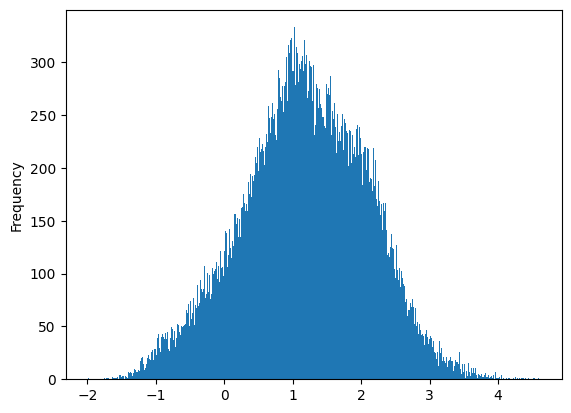

In [22]:
np.log10(illu_tot_nuc_cito[illu_tot_nuc_cito.mean(axis=1)>0].sum(axis=1)).plot(kind="hist", bins=500)

<Axes: ylabel='Frequency'>

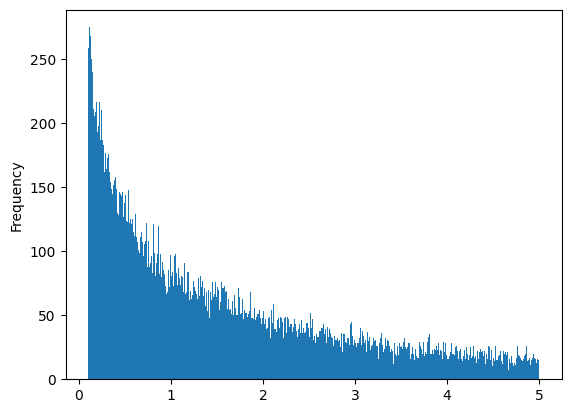

In [23]:
illu_tot_nuc_cito[illu_tot_nuc_cito.mean(axis=1).between(0.1,5)].mean(axis=1).plot(kind="hist", bins=500)

<Axes: xlabel='gene,isoform'>

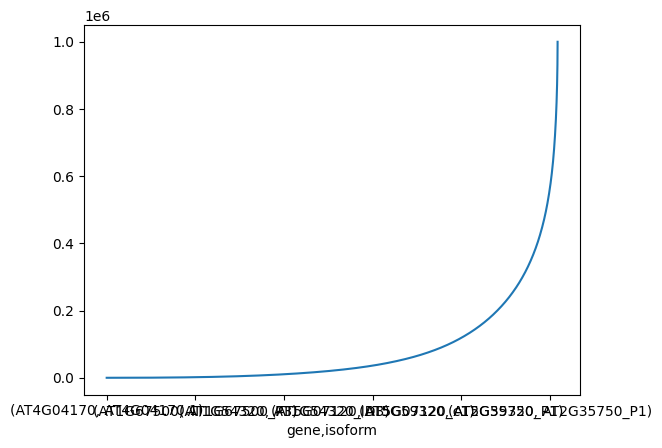

In [24]:
illu_tot_nuc_cito[illu_tot_nuc_cito.mean(axis=1)>0].mean(axis=1).sort_values().cumsum().plot()

In [25]:
illu_tot_nuc_cito.columns.set_names(["condition", "sample"], inplace=True)
ONT_nuc_cito.columns.set_names(["condition", "sample"], inplace=True)
ONT_total.columns.set_names(["condition", "sample"], inplace=True)

In [26]:
ONT_nuc_cito_total = pd.concat([ONT_nuc_cito,ONT_total],axis=1)
ONT_nuc_cito_total.loc[["AT3G02300",],:]

condition                    Nuc L                             Nuc D   
sample                       TPM_1      TPM_2      TPM_3       TPM_1   
gene      isoform                                                      
AT3G02300 AT3G02300_ID1  73.366232  65.926072  83.050709  160.769449  \
          AT3G02300_ID3  13.890834  25.278806  12.234233   82.624468   
          AT3G02300_ID4   4.094622   0.000000  27.640688    2.717614   
          AT3G02300_P1    1.796996   5.478444   0.000000    0.000000   

condition                                            Cit L             
sample                        TPM_2       TPM_3      TPM_1     TPM_2   
gene      isoform                                                      
AT3G02300 AT3G02300_ID1  112.540453   91.718352   0.000000  0.000000  \
          AT3G02300_ID3  104.760731  108.874522   3.809791  6.659607   
          AT3G02300_ID4   15.078994    3.408466   0.000000  0.000000   
          AT3G02300_P1     1.362074    0.000000  12.133070  6.659607   

condition                             Cit D                          Total D   
sample                      TPM_3     TPM_1      TPM_2      TPM_3      TPM_1   
gene      isoform                                                              
AT3G02300 AT3G02300_ID1  2.424313  7.850399   4.221919   0.000000  43.654222  \
          AT3G02300_ID3  0.000000  7.765852  22.935495  25.782079  38.815080   
          AT3G02300_ID4  0.000000  0.000000   0.000000   3.774997   0.000000   
          AT3G02300_P1   4.848626  0.000000   0.000000   0.000000   0.000000   

condition                  Total L  
sample                       TPM_1  
gene      isoform                   
AT3G02300 AT3G02300_ID1  26.515220  
          AT3G02300_ID3   0.000000  
          AT3G02300_ID4   0.000000  
          AT3G02300_P1   34.123484

In [27]:
from matplotlib_venn import venn2, venn2_circles, venn3
from venn import venn
%matplotlib inline


In [28]:
illu_polyribosomes_TPM_4 = illu_polyribosomes[(illu_polyribosomes > 1).all(axis=1)]

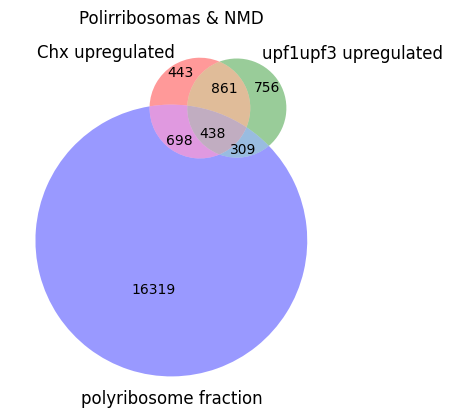

In [29]:
NMD_isoforms_chx_set = set(filt_pval_table_Chx_Mock.index.get_level_values("isoform").to_series().tolist())
NMD_isoforms_upf13_set = set(filt_pval_table_upf1upf3_wt.index.get_level_values("isoform").to_series().tolist())
polyribo_isoforms_set = set(illu_polyribosomes_TPM_4.index.get_level_values("isoform").to_series().tolist())

venn3(subsets = (NMD_isoforms_chx_set, NMD_isoforms_upf13_set, polyribo_isoforms_set), set_labels = ('Chx upregulated', 'upf1upf3 upregulated', 'polyribosome fraction'))
plt.title("Polirribosomas & NMD")

plt.savefig("./NMD_and_polyribosome.png")
plt.show()

In [30]:
ONT_nuc = ONT_nuc_cito_total.loc[:,["Nuc L","Nuc D" ]]
ONT_nuc_D = ONT_nuc[ONT_nuc.groupby("condition", axis=1).mean() > 5].loc[:,["Nuc D"]].dropna(how="all")
ONT_nuc_D = ONT_nuc_D.loc[(ONT_nuc_D != 0).all(axis=1)].index.get_level_values("isoform").to_series()
ONT_nuc_L = ONT_nuc[ONT_nuc.groupby("condition", axis=1).mean() > 5].loc[:,["Nuc L"]].dropna(how="all")
ONT_nuc_L = ONT_nuc_L.loc[(ONT_nuc_L != 0).all(axis=1)].index.get_level_values("isoform").to_series()
ONT_nuc_isoforms = pd.concat([ONT_nuc_D, ONT_nuc_L], axis=0).unique()
print(f"ONT_nuc_D: {len(ONT_nuc_D)}, ONT_nuc_L: {len(ONT_nuc_L)}")

# mean() >2
#ONT_nuc_D: 19259, ONT_nuc_L: 15780
#mean() >5
#ONT_nuc_D: 17067, ONT_nuc_L: 15482

ONT_nuc_D: 17067, ONT_nuc_L: 15482


In [31]:
ONT_cit = ONT_nuc_cito_total.loc[:,["Cit L","Cit D" ]]
ONT_cit_D = ONT_cit[ONT_cit.groupby("condition", axis=1).mean() > 5].loc[:,["Cit D"]].dropna(how="all")
ONT_cit_D = ONT_cit_D.loc[(ONT_cit_D != 0).all(axis=1)].index.get_level_values("isoform").to_series()
ONT_cit_L = ONT_cit[ONT_cit.groupby("condition", axis=1).mean() > 5].loc[:,["Cit L"]].dropna(how="all")
display(ONT_cit_L)
ONT_cit_L = ONT_cit_L.loc[(ONT_cit_L != 0).all(axis=1)].index.get_level_values("isoform").to_series()
ONT_cit_isoforms = pd.concat([ONT_cit_D, ONT_cit_L], axis=0).unique()
print(f"ONT_cit_D: {len(ONT_cit_D)}, ONT_cit_L: {len(ONT_cit_L)}")
ONT_cit_isoforms_set = set(ONT_cit_isoforms.tolist())

# mean() >2
#ONT_cit_D: 11704, ONT_cit_L: 12940
#mean() >5
#ONT_cit_D: 10608, ONT_cit_L: 11620


condition                    Cit L                        
sample                       TPM_1       TPM_2       TPM_3
gene      isoform                                         
AT1G01010 AT1G01010.1     6.642859    8.879477    9.697252
AT1G01020 AT1G01020_P1   23.914291    8.879477   19.394504
AT1G01040 AT1G01040.2     0.000000   19.978822    0.000000
          AT1G01040_P1   21.257148    0.000000    9.697252
AT1G01050 AT1G01050_P1  121.095980  129.710194  130.359282
...                            ...         ...         ...
ATMG00990 ATMG00990.1     7.370555    2.383206    8.490590
ATMG01080 ATMG01080.1     3.985715   11.099346    4.848626
ATMG01170 ATMG01170.1    10.628457   22.710595   15.345217
ATMG01380 ATMG01380.1     6.642859    8.879477    0.000000
ATMG01390 ATMG01390.1   178.028612  237.526000  322.569007

[16746 rows x 3 columns]

ONT_cit_D: 10608, ONT_cit_L: 11620


In [32]:
ONT_cit_isoforms

array(['AT1G01010.1', 'AT1G01050_P1', 'AT1G01050_c1', ...,
       'ATMG00250_JC1', 'ATMG00660.1', 'ATMG00990.1'], dtype=object)

In [33]:
len(ONT_nuc_isoforms)


21568

In [34]:
illu_cit = illu_tot_nuc_cito.loc[:,["Cit L","Cit D" ]]
print("illu cit")
display(illu_cit.head())
display(illu_cit[illu_cit.groupby("condition", axis=1).mean() > 2].groupby("condition", axis=1).mean().head())
illu_cit_D = illu_cit[illu_cit.groupby("condition", axis=1).mean() > 2].groupby("condition", axis=1).mean().loc[:,["Cit D"]].dropna(how="all").index.get_level_values("isoform").to_series()
illu_cit_L = illu_cit[illu_cit.groupby("condition", axis=1).mean() > 2].groupby("condition", axis=1).mean().loc[:,["Cit L"]].dropna(how="all").index.get_level_values("isoform").to_series()
illu_cit_isoforms = pd.concat([illu_cit_D, illu_cit_L], axis=0).unique()
print(f"illu_cit_D: {len(illu_cit_D)}, illu_cit_L: {len(illu_cit_L)}")
illu_cit_isoforms_set = set(illu_cit_isoforms.tolist())
illu_cit

illu_nuc = illu_tot_nuc_cito.loc[:,["Nuc L","Nuc D" ]]
print("illu nuc")
display(illu_nuc.head())
illu_nuc_D = illu_nuc[illu_nuc.groupby("condition", axis=1).mean() > 2].groupby("condition", axis=1).mean().loc[:,["Nuc D"]].dropna(how="all").index.get_level_values("isoform").to_series()
illu_nuc_L = illu_nuc[illu_nuc.groupby("condition", axis=1).mean() > 2].groupby("condition", axis=1).mean().loc[:,["Nuc L"]].dropna(how="all").index.get_level_values("isoform").to_series()
illu_nuc_isoforms = pd.concat([illu_nuc_D, illu_nuc_L], axis=0).unique()
print(f"illu_nuc_D: {len(illu_nuc_D)}, illu_nuc_L: {len(illu_nuc_L)}")
illu_nuc_isoforms_set = set(illu_nuc_isoforms.tolist())
illu_nuc

# mean() >2
#illu_cit_D: 19486, illu_cit_L: 20185
#illu_nuc_D: 28534, illu_nuc_L: 32177
# mean() >5
#illu_cit_D: 14109, illu_cit_L: 14506
#illu_nuc_D: 20573, illu_nuc_L: 23374
# mean() >25
#illu_cit_D: 5642, illu_cit_L: 5635
#illu_nuc_D: 7268, illu_nuc_L: 8251

illu cit


condition                  Cit L      Cit D
sample                     TPM_1      TPM_1
gene      isoform                          
AT1G01010 AT1G01010.1   6.754882  16.177555
AT1G01020 AT1G01020_P1  5.629857   7.261125
          AT1G01020_P2  0.000000   0.000000
          AT1G01020_P3  0.263974   0.183908
          AT1G01020_P4  0.000000   0.187789

condition                   Cit D     Cit L
gene      isoform                          
AT1G01010 AT1G01010.1   16.177555  6.754882
AT1G01020 AT1G01020_P1   7.261125  5.629857
          AT1G01020_P2        NaN       NaN
          AT1G01020_P3        NaN       NaN
          AT1G01020_P4        NaN       NaN

illu_cit_D: 19486, illu_cit_L: 20185
illu nuc


condition                   Nuc L      Nuc D
sample                      TPM_1      TPM_1
gene      isoform                           
AT1G01010 AT1G01010.1   12.240711  14.693500
AT1G01020 AT1G01020_P1  33.751283  28.672398
          AT1G01020_P2   1.293679   0.667937
          AT1G01020_P3  12.378573  16.577624
          AT1G01020_P4   5.236000   5.255813

illu_nuc_D: 28534, illu_nuc_L: 32177


condition                    Nuc L       Nuc D
sample                       TPM_1       TPM_1
gene      isoform                             
AT1G01010 AT1G01010.1    12.240711   14.693500
AT1G01020 AT1G01020_P1   33.751283   28.672398
          AT1G01020_P2    1.293679    0.667937
          AT1G01020_P3   12.378573   16.577624
          AT1G01020_P4    5.236000    5.255813
...                            ...         ...
ATMG01330 ATMG01330.1     0.281026    0.758931
ATMG01350 ATMG01350.1     0.448757    0.595284
ATMG01370 ATMG01370.1     9.977111    3.211860
ATMG01380 ATMG01380.1   106.153767   39.965637
ATMG01390 ATMG01390.1   102.855935  107.624265

[54095 rows x 2 columns]

/home/petrys/miniconda3/lib/python3.10/site-packages/matplotlib_venn/_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")


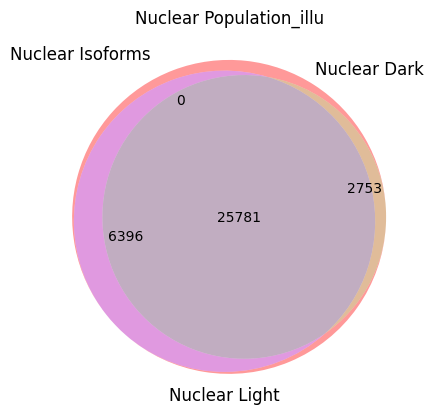

In [35]:
illu_nuc_D_set = set(illu_nuc_D.tolist())
illu_nuc_L_set = set(illu_nuc_L.tolist())
illu_nuc_isoforms_set = set(illu_nuc_isoforms.tolist())

venn3(subsets = (illu_nuc_isoforms_set, illu_nuc_D_set, illu_nuc_L_set), set_labels = ('Nuclear Isoforms', 'Nuclear Dark', 'Nuclear Light'))
plt.title("Nuclear Population_illu")

plt.savefig("./Nuclear_population_illu.png")
plt.show()

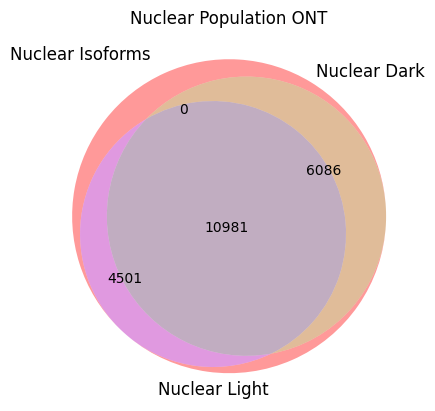

In [36]:
ONT_nuc_D_set = set(ONT_nuc_D.tolist())
ONT_nuc_L_set = set(ONT_nuc_L.tolist())
ONT_nuc_isoforms_set = set(ONT_nuc_isoforms.tolist())

venn3(subsets = (ONT_nuc_isoforms_set, ONT_nuc_D_set, ONT_nuc_L_set), set_labels = ('Nuclear Isoforms', 'Nuclear Dark', 'Nuclear Light'))
plt.title("Nuclear Population ONT")

plt.savefig("./Nuclear_population.png")
plt.show()

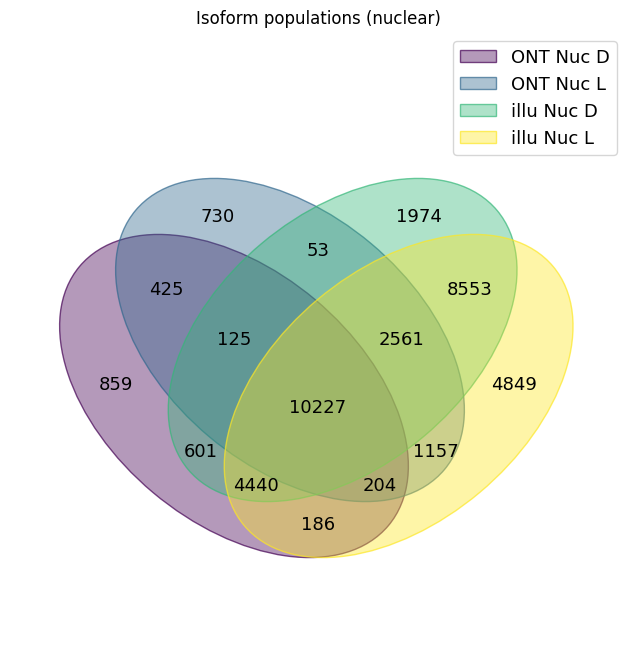

In [37]:
groups = {
    "ONT Nuc D":ONT_nuc_D_set,
    "ONT Nuc L": ONT_nuc_L_set,
    "illu Nuc D": illu_nuc_D_set,
    "illu Nuc L": illu_nuc_L_set
}
venn(groups)
plt.title("Isoform populations (nuclear)")

plt.savefig("./Isoform_populations_nuclear.png")

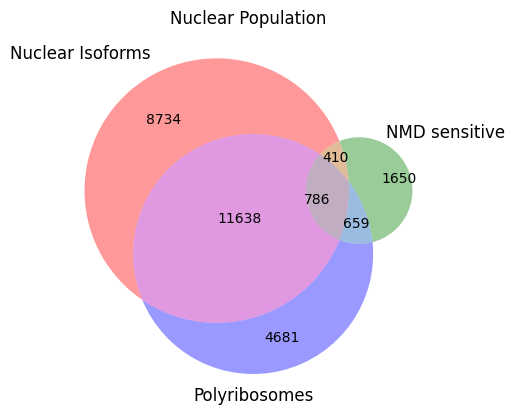

In [38]:
NMD_isoforms_set = NMD_isoforms_upf13_set.union(NMD_isoforms_chx_set)
venn3(subsets = (ONT_nuc_isoforms_set, NMD_isoforms_set, polyribo_isoforms_set), set_labels = ('Nuclear Isoforms', 'NMD sensitive', 'Polyribosomes'))
plt.title("Nuclear Population")

plt.savefig("./Nuclear_NMD_Polyribosomes.png")
plt.show()

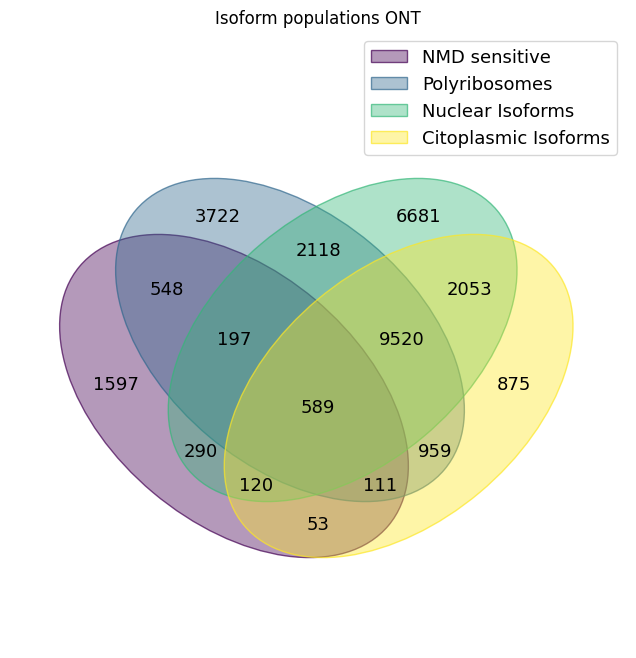

In [39]:
groups = {
    "NMD sensitive":NMD_isoforms_set,
    "Polyribosomes": polyribo_isoforms_set,
    "Nuclear Isoforms": ONT_nuc_isoforms_set,
    "Citoplasmic Isoforms": ONT_cit_isoforms_set
}
venn(groups)
plt.title("Isoform populations ONT")

plt.savefig("./Isoform_populations_ONT.png")

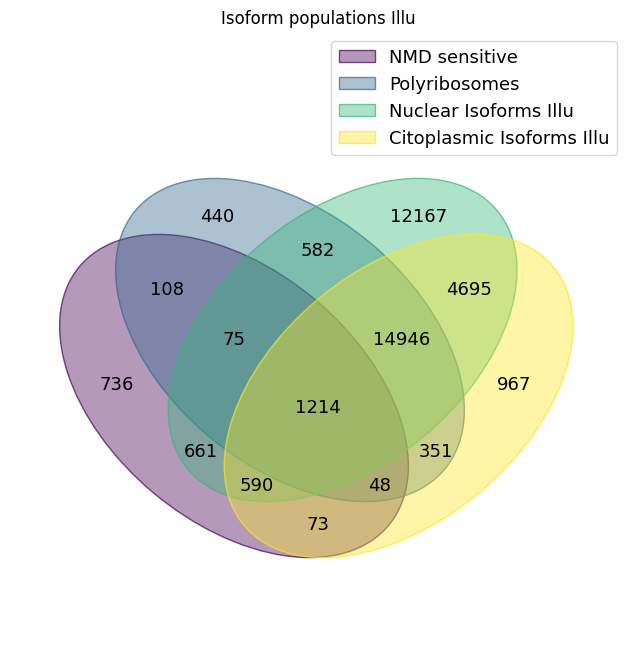

In [40]:
groups = {
    "NMD sensitive":NMD_isoforms_set,
    "Polyribosomes": polyribo_isoforms_set,
    "Nuclear Isoforms Illu": illu_nuc_isoforms_set,
    "Citoplasmic Isoforms Illu": illu_cit_isoforms_set
}
venn(groups)
plt.title("Isoform populations Illu")

plt.savefig("./Isoform_populations_illu.png")


In [41]:
result = [i for i in illu_nuc_isoforms_set if i not in illu_cit_isoforms_set]
result2 = [i for i in result if i not in NMD_isoforms_set]
result3_illu = [i for i in result2 if i not in polyribo_isoforms_set]
print(f" illu = {len(result3_illu)}")

result = [i for i in ONT_nuc_isoforms_set if i not in ONT_cit_isoforms_set]
result2 = [i for i in result if i not in NMD_isoforms_set]
result3_ONT = [i for i in result2 if i not in polyribo_isoforms_set]
print(f" ONT = {len(result3_ONT)}")

 illu = 12167
 ONT = 6681


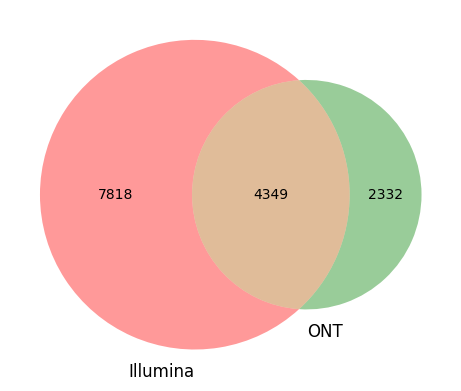

In [42]:
from matplotlib_venn import venn2
venn2([set(result3_illu), set(result3_ONT)], set_labels=('Illumina', 'ONT'))

plt.show()

#Add chromatin bound

In [43]:
result3_illu_series = pd.Series(list(result3_ONT))
for i in ['AT3G61860',"AT1G09140","AT4G36690","AT3G02300"]:
    result = result3_illu_series[result3_illu_series.str.contains(i)]
    print(result)

2547     AT3G61860_s1
5112    AT3G61860_ID2
dtype: object
2934    AT1G09140_ID154
4493      AT1G09140_CR3
4615    AT1G09140_ID157
dtype: object
2729     AT4G36690_P3
4868    AT4G36690_JC2
5780     AT4G36690_P2
dtype: object
926     AT3G02300_ID1
2465    AT3G02300_ID4
dtype: object


In [44]:
illu_tot_nuc_cito.loc[["AT3G61860",],:]

condition                  Total L    Total D       Nuc L       Nuc D   
sample                       TPM_1      TPM_1       TPM_1       TPM_1   
gene      isoform                                                       
AT3G61860 AT3G61860_ID2  21.075251  94.059302  101.020106  448.805449  \
          AT3G61860_P1   41.206209  38.287691   33.357500   25.528555   
          AT3G61860_s1    3.679035  14.592991   17.974293   56.742832   
          AT3G61860_s2    1.092008   1.158863    5.816786    2.702435   

condition                    Cit L      Cit D  
sample                       TPM_1      TPM_1  
gene      isoform                              
AT3G61860 AT3G61860_ID2   2.477672  11.222142  
          AT3G61860_P1   48.884969  39.036327  
          AT3G61860_s1    0.596668   0.996456  
          AT3G61860_s2    1.057176   0.358459

In [45]:
ONT_nuc_cito_total.loc[["AT3G61860",],:]

condition                     Nuc L                               Nuc D   
sample                        TPM_1       TPM_2       TPM_3       TPM_1   
gene      isoform                                                         
AT3G61860 AT3G61860_ID2  139.018994  131.462047  270.678521  551.881961  \
          AT3G61860_P1    45.001106   54.993979   55.856642   47.668880   
          AT3G61860_s1    19.074574   26.686754    9.461560   52.362911   
          AT3G61860_s2     0.000000    0.000000    0.000000    0.000000   

condition                                            Cit L               
sample                        TPM_2       TPM_3      TPM_1       TPM_2   
gene      isoform                                                        
AT3G61860 AT3G61860_ID2  559.283641  569.016229   4.501291    0.000000  \
          AT3G61860_P1    37.396246   46.008744  76.541585  108.773589   
          AT3G61860_s1    61.452688   52.836558   0.000000    0.000000   
          AT3G61860_s2     1.540005    0.000000   0.000000    0.000000   

condition                               Cit D                         
sample                       TPM_3      TPM_1      TPM_2      TPM_3   
gene      isoform                                                     
AT3G61860 AT3G61860_ID2   0.000000  11.534775   0.000000  12.200213  \
          AT3G61860_P1   80.002327  35.313977  46.555567  46.913939   
          AT3G61860_s1    0.000000   0.000000   0.000000   0.000000   
          AT3G61860_s2    0.000000   0.000000   0.000000   0.000000   

condition                  Total D    Total L  
sample                       TPM_1      TPM_1  
gene      isoform                              
AT3G61860 AT3G61860_ID2  56.935881   9.884961  
          AT3G61860_P1   35.627372  40.052795  
          AT3G61860_s1   18.343739   0.000000  
          AT3G61860_s2    0.000000   0.000000

___
## Looking for proportions of nuclear and citoplasmatic enrichment

In [46]:
proportion_ONT_nuc_cito_total = ONT_nuc_cito_total.groupby("condition", axis=1).mean()
proportion_ONT_nuc_cito_total["Cit D P"] = proportion_ONT_nuc_cito_total.apply(lambda x: 
                            x["Cit D"]/x["Total D"], axis=1)
proportion_ONT_nuc_cito_total["Cit L P"] = proportion_ONT_nuc_cito_total.apply(lambda x: 
                            x["Cit L"]/x["Total L"], axis=1)
proportion_ONT_nuc_cito_total["Nuc D P"] = proportion_ONT_nuc_cito_total.apply(lambda x: 
                            x["Nuc D"]/x["Total D"], axis=1)
proportion_ONT_nuc_cito_total["Nuc L P"] = proportion_ONT_nuc_cito_total.apply(lambda x: 
                            x["Nuc L"]/x["Total L"], axis=1)

proportion_ONT_nuc_cito_total.loc[["AT5G37055",],:]

condition                    Cit D      Cit L      Nuc D      Nuc L   
gene      isoform                                                     
AT5G37055 AT5G37055_ID2   3.702121   2.681536   7.640615   7.191203  \
          AT5G37055_ID3   4.370255   5.905734  53.846510  32.652799   
          AT5G37055_P1   20.650980  16.062627  16.186307   1.174531   

condition                  Total D   Total L   Cit D P   Cit L P   Nuc D P   
gene      isoform                                                            
AT5G37055 AT5G37055_ID2  19.906383  3.566983  0.185977  0.751766  0.383827  \
          AT5G37055_ID3   0.000000  0.000000       inf       inf       inf   
          AT5G37055_P1    0.000000  0.000000       inf       inf       inf   

condition                 Nuc L P  
gene      isoform                  
AT5G37055 AT5G37055_ID2  2.016046  
          AT5G37055_ID3       inf  
          AT5G37055_P1        inf

In [47]:
proportion_cols = ["Cit D P","Cit L P","Nuc D P","Nuc L P"]
prop_ONT_nuc_cito_total = proportion_ONT_nuc_cito_total.loc[:,proportion_cols].fillna(0).replace(np.inf, 1)
prop_ONT_nuc_cito_total

condition                Cit D P   Cit L P   Nuc D P   Nuc L P
gene      isoform                                             
AT1G01010 AT1G01010.1   0.993784  1.178381  0.750200  0.584704
AT1G01020 AT1G01020_P1  1.000000  1.000000  1.000000  1.000000
          AT1G01020_P2  1.000000  0.000000  0.000000  1.000000
          AT1G01020_P3  0.486757  0.000000  9.463167  6.522294
          AT1G01020_P4  0.000000  0.000000  0.000000  0.000000
...                          ...       ...       ...       ...
ATMG01330 ATMG01330.1   0.000000  0.000000  0.000000  0.000000
ATMG01350 ATMG01350.1   0.259029  0.000000  0.000000  1.000000
ATMG01370 ATMG01370.1   0.261495  0.193140  0.152212  0.209730
ATMG01380 ATMG01380.1   1.000000  1.438101  1.000000  0.893684
ATMG01390 ATMG01390.1   0.562745  0.450833  0.196538  0.302419

[54095 rows x 4 columns]

In [48]:
cit_prop_ONT_nuc_cito_total = pd.concat([prop_ONT_nuc_cito_total["Cit D P"], prop_ONT_nuc_cito_total["Cit L P"]])
cit_prop_ONT = cit_prop_ONT_nuc_cito_total[cit_prop_ONT_nuc_cito_total > 1].index.get_level_values("isoform").to_series()

nuc_prop_ONT_nuc_cito_total = pd.concat([prop_ONT_nuc_cito_total["Nuc D P"], prop_ONT_nuc_cito_total["Nuc L P"]])
nuc_prop_ONT = nuc_prop_ONT_nuc_cito_total[nuc_prop_ONT_nuc_cito_total > 1].index.get_level_values("isoform").to_series()
print(len(cit_prop_ONT))
print(len(nuc_prop_ONT))

8292
13635


In [49]:
illu_tot_nuc_cito
proportion_illu_tot_nuc_cito = illu_tot_nuc_cito.groupby("condition", axis=1).mean()
proportion_illu_tot_nuc_cito["Cit D P"] = proportion_illu_tot_nuc_cito.apply(lambda x: 
                            x["Cit D"]/x["Total D"], axis=1)
proportion_illu_tot_nuc_cito["Cit L P"] = proportion_illu_tot_nuc_cito.apply(lambda x: 
                            x["Cit L"]/x["Total L"], axis=1)
proportion_illu_tot_nuc_cito["Nuc D P"] = proportion_illu_tot_nuc_cito.apply(lambda x: 
                            x["Nuc D"]/x["Total D"], axis=1)
proportion_illu_tot_nuc_cito["Nuc L P"] = proportion_illu_tot_nuc_cito.apply(lambda x: 
                            x["Nuc L"]/x["Total L"], axis=1)

proportion_illu_tot_nuc_cito.loc[["AT3G61860",],:]

condition                    Cit D      Cit L       Nuc D       Nuc L   
gene      isoform                                                       
AT3G61860 AT3G61860_ID2  11.222142   2.477672  448.805449  101.020106  \
          AT3G61860_P1   39.036327  48.884969   25.528555   33.357500   
          AT3G61860_s1    0.996456   0.596668   56.742832   17.974293   
          AT3G61860_s2    0.358459   1.057176    2.702435    5.816786   

condition                  Total D    Total L   Cit D P   Cit L P   Nuc D P   
gene      isoform                                                             
AT3G61860 AT3G61860_ID2  94.059302  21.075251  0.119309  0.117563  4.771516  \
          AT3G61860_P1   38.287691  41.206209  1.019553  1.186350  0.666756   
          AT3G61860_s1   14.592991   3.679035  0.068283  0.162181  3.888362   
          AT3G61860_s2    1.158863   1.092008  0.309320  0.968103  2.331971   

condition                 Nuc L P  
gene      isoform                  
AT3G61860 AT3G61860_ID2  4.793305  
          AT3G61860_P1   0.809526  
          AT3G61860_s1   4.885600  
          AT3G61860_s2   5.326688

In [50]:
proportion_cols = ["Cit D P","Cit L P","Nuc D P","Nuc L P"]
prop_illu_tot_nuc_cito = proportion_illu_tot_nuc_cito.loc[:,proportion_cols].fillna(0).replace(np.inf, 0)
prop_illu_tot_nuc_cito

condition                Cit D P   Cit L P    Nuc D P    Nuc L P
gene      isoform                                               
AT1G01010 AT1G01010.1   0.706571  0.680901   0.641754   1.233880
AT1G01020 AT1G01020_P1  0.753597  0.531643   2.975769   3.187228
          AT1G01020_P2  0.000000  0.000000  11.335953  21.681650
          AT1G01020_P3  0.046714  0.220539   4.210849  10.341789
          AT1G01020_P4  0.170635  0.000000   4.775702   4.116009
...                          ...       ...        ...        ...
ATMG01330 ATMG01330.1   0.833807  0.734613   0.574124   0.239548
ATMG01350 ATMG01350.1   1.851874  1.054527   0.973211   1.066762
ATMG01370 ATMG01370.1   1.209764  1.543056   0.428727   0.691814
ATMG01380 ATMG01380.1   1.611442  1.957205   1.021774   0.860123
ATMG01390 ATMG01390.1   1.768146  1.123568   1.765189   2.213655

[54095 rows x 4 columns]

In [51]:
cit_prop_illu_tot_nuc_cito = pd.concat([prop_illu_tot_nuc_cito["Cit D P"], prop_illu_tot_nuc_cito["Cit L P"]])
cit_prop_illu = cit_prop_illu_tot_nuc_cito[cit_prop_illu_tot_nuc_cito > 1].index.get_level_values("isoform").to_series()

nuc_prop_illu_tot_nuc_cito = pd.concat([prop_illu_tot_nuc_cito["Nuc D P"], prop_illu_tot_nuc_cito["Nuc L P"]])
nuc_prop_illu = nuc_prop_illu_tot_nuc_cito[nuc_prop_illu_tot_nuc_cito > 1].index.get_level_values("isoform").to_series()
print(len(cit_prop_illu))
print(len(result3_illu))

19853
12167


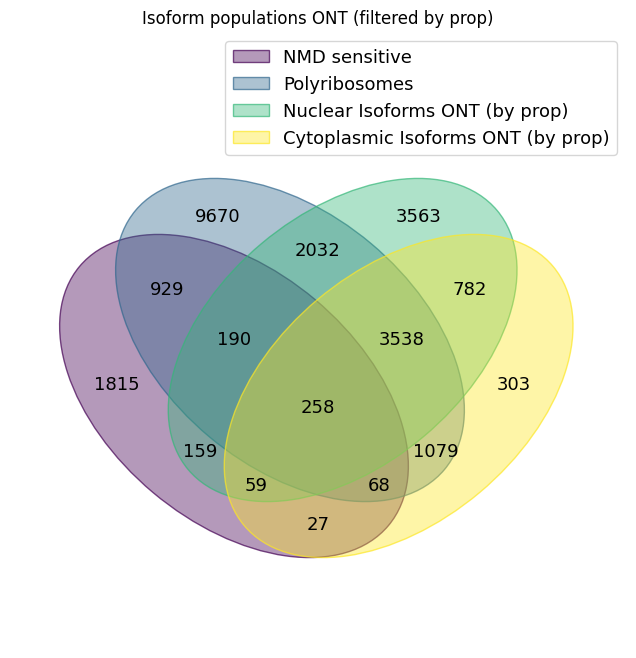

In [52]:
groups = {
    "NMD sensitive":NMD_isoforms_set,
    "Polyribosomes": polyribo_isoforms_set,
    "Nuclear Isoforms ONT (by prop)": set(nuc_prop_ONT),
    "Cytoplasmic Isoforms ONT (by prop)": set(cit_prop_ONT)
}
venn(groups)
plt.title("Isoform populations ONT (filtered by prop)")

plt.savefig("./Isoform_populations_ONT_by_prop.png")


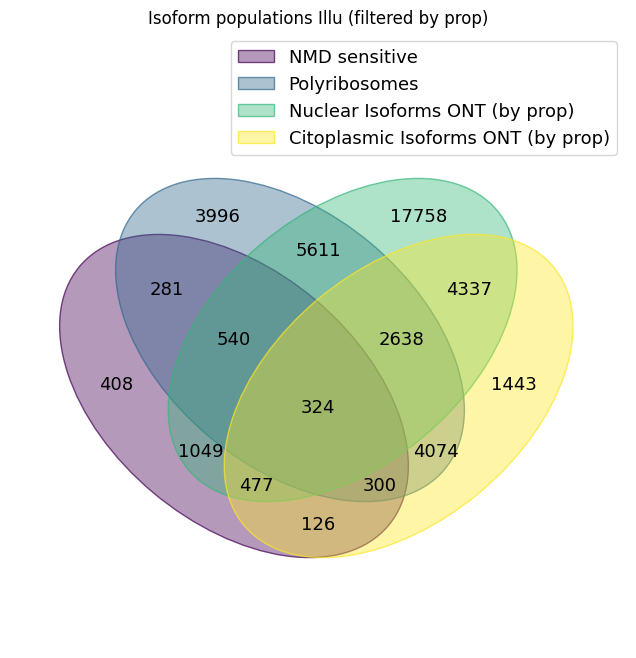

In [53]:
groups = {
    "NMD sensitive":NMD_isoforms_set,
    "Polyribosomes": polyribo_isoforms_set,
    "Nuclear Isoforms ONT (by prop)": set(nuc_prop_illu),
    "Citoplasmic Isoforms ONT (by prop)": set(cit_prop_illu)
}
venn(groups)
plt.title("Isoform populations Illu (filtered by prop)")

plt.savefig("./Isoform_populations_illu_by_prop.png")


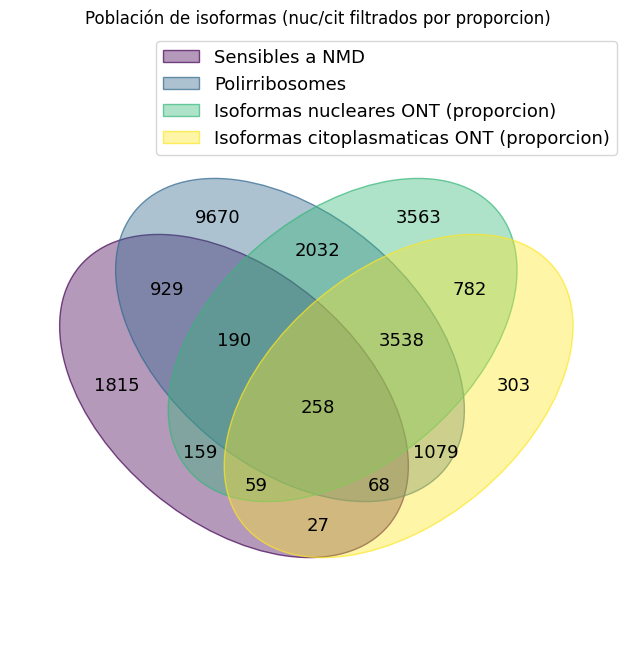

In [54]:
groups = {
    "Sensibles a NMD":NMD_isoforms_set,
    "Polirribosomes": polyribo_isoforms_set,
    "Isoformas nucleares ONT (proporcion)": set(nuc_prop_ONT),
    "Isoformas citoplasmaticas ONT (proporcion)": set(cit_prop_ONT)
}
venn(groups)
plt.title("Población de isoformas (nuc/cit filtrados por proporcion)")

plt.savefig("./Isoform_populations_ONT_by_prop.png")


In [55]:
result = [i for i in set(nuc_prop_ONT) if i not in set(cit_prop_ONT)]
result2 = [i for i in result if i not in NMD_isoforms_set]
result3_ONT_prop = [i for i in result2 if i not in polyribo_isoforms_set]
print(f" ONT = {len(result3_ONT_prop)}")

 ONT = 3563


In [56]:
result = [i for i in set(nuc_prop_illu) if i not in set(cit_prop_illu)]
result2 = [i for i in result if i not in NMD_isoforms_set]
result3_illu_prop = [i for i in result2 if i not in polyribo_isoforms_set]
print(f" illu = {len(result3_illu_prop)}")


 illu = 17758


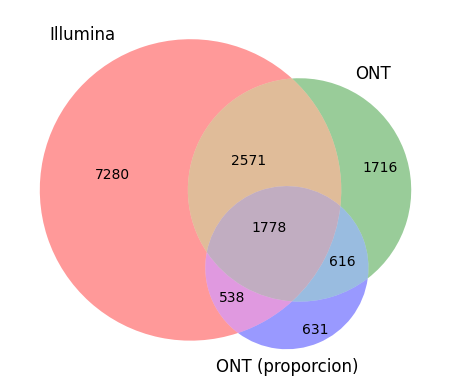

In [57]:
from matplotlib_venn import venn2
venn3([set(result3_illu), set(result3_ONT), set(result3_ONT_prop)], set_labels=('Illumina', 'ONT', "ONT (proporcion)"))
plt.savefig("./different_nuclear_filtering_ONT.png")
plt.show()


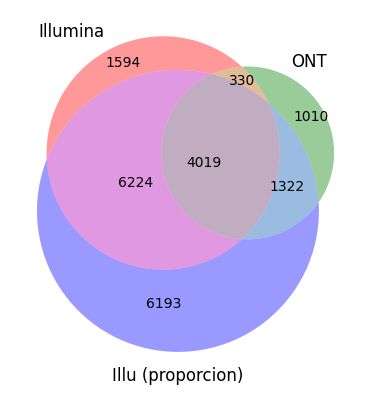

In [58]:
from matplotlib_venn import venn2
venn3([set(result3_illu), set(result3_ONT), set(result3_illu_prop)], set_labels=('Illumina', 'ONT', "Illu (proporcion)"))
plt.savefig("./different_nuclear_filtering_illu.png")
plt.show()


----------

### Filtering Nucleus and citoplasm using both sequencings and using the "proportion" filtering
Figuras para TESIS

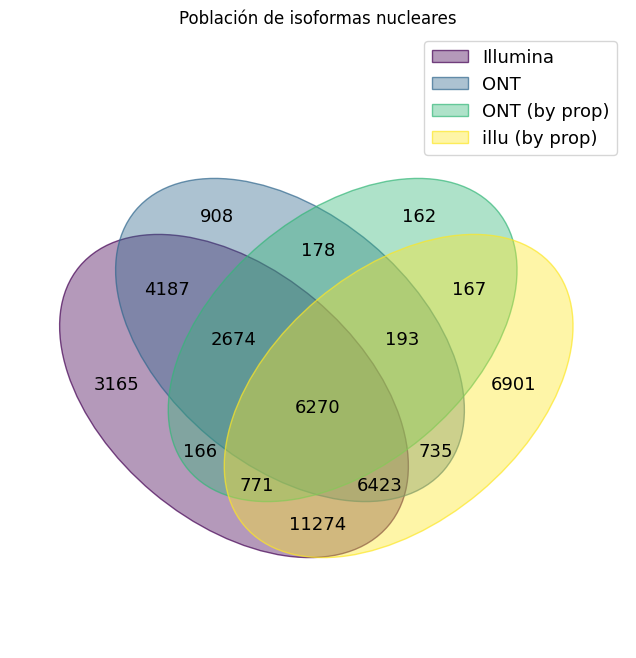

In [59]:
groups = {
    "Illumina":set(illu_nuc_isoforms_set),
    "ONT": set(ONT_nuc_isoforms_set),
    "ONT (by prop)": set(nuc_prop_ONT),
    "illu (by prop)": set(nuc_prop_illu)
}
venn(groups)
plt.title("Población de isoformas nucleares")

plt.savefig("./Isoform_populations_nuclear.png")

In [60]:
result_nuc = [i for i in set(illu_nuc_isoforms_set) if i in set(ONT_nuc_isoforms_set)]
result2_nuc = [i for i in result_nuc if i in set(nuc_prop_ONT)]
result3_nuc_total_prop = [i for i in result2_nuc if i in set(nuc_prop_illu)]
print(f" NUCLEO MAXIMO = {len(result3_nuc_total_prop)}")

 NUCLEO MAXIMO = 6270


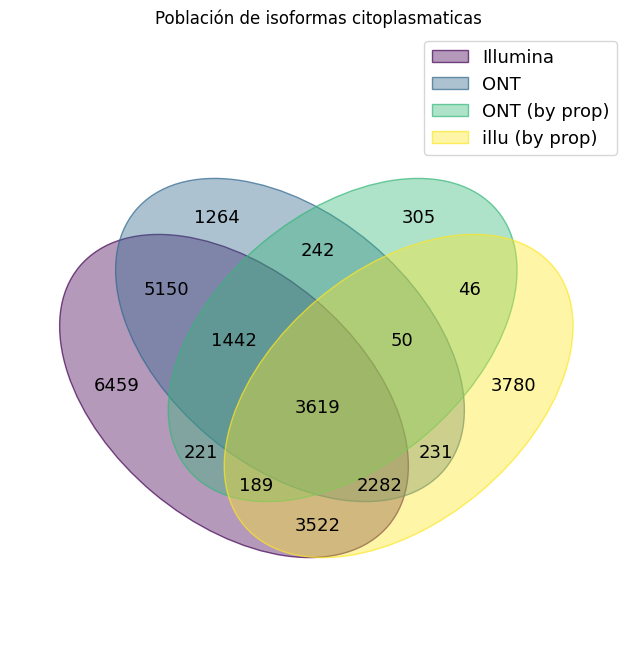

In [61]:
groups = {
    "Illumina":set(illu_cit_isoforms_set),
    "ONT": set(ONT_cit_isoforms_set),
    "ONT (by prop)": set(cit_prop_ONT),
    "illu (by prop)": set(cit_prop_illu)
}
venn(groups)
plt.title("Población de isoformas citoplasmaticas")

plt.savefig("./Isoform_populations_citoplasm.png")

In [62]:
result_cit = [i for i in set(illu_cit_isoforms_set) if i in set(ONT_cit_isoforms_set)]
result2_cit = [i for i in result_cit if i in set(cit_prop_ONT)]
result3_cit_total_prop = [i for i in result2_cit if i in set(cit_prop_illu)]
print(f" CITOPLASMA MAXIMO = {len(result3_cit_total_prop)}")

 CITOPLASMA MAXIMO = 3619


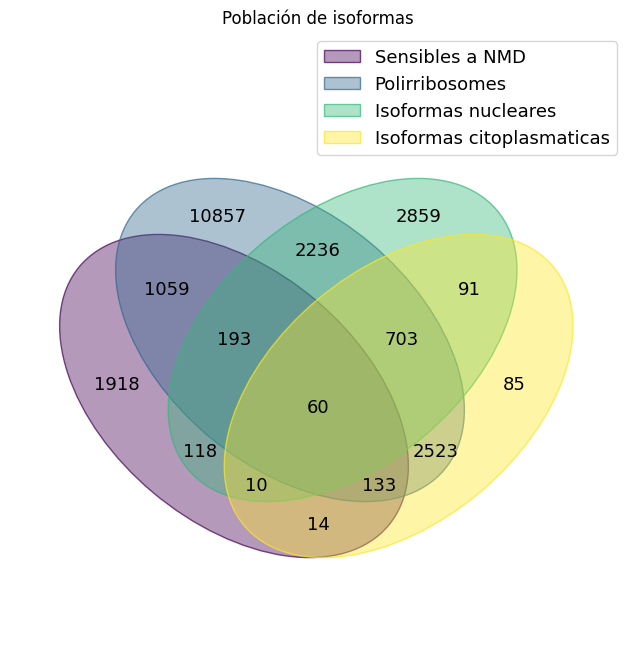

In [63]:
groups = {
    "Sensibles a NMD":NMD_isoforms_set,
    "Polirribosomes": polyribo_isoforms_set,
    "Isoformas nucleares": set(result3_nuc_total_prop),
    "Isoformas citoplasmaticas": set(result3_cit_total_prop)
}
venn(groups)
plt.title("Población de isoformas")

plt.savefig("./Isoform_populations_ONT_by_prop.png")


### Estudio del grupo final
De las 2859 isoformas debo buscar los genes de interés y filtrar aun mas por expresión

In [64]:
result_nuc_final = [i for i in set(result3_nuc_total_prop) if i not in set(result3_cit_total_prop)]
result2_nuc_final = [i for i in result_nuc_final if i not in set(polyribo_isoforms_set)]
result3_nuc_final = [i for i in result2_nuc_final if i not in set(NMD_isoforms_set)]
print(f" Grupo nuclear final = {len(result3_nuc_final)}")

 Grupo nuclear final = 2859


In [65]:
result3_illu_series = pd.Series(list(result3_nuc_final))
for i in ['AT3G61860',"AT1G09140","AT4G36690","AT3G02300"]:
    result = result3_illu_series[result3_illu_series.str.contains(i)]
    print(result)

225     AT3G61860_ID2
1613     AT3G61860_s1
dtype: object
1996    AT1G09140_CR3
dtype: object
1273    AT4G36690_P2
1904    AT4G36690_P3
dtype: object
1626    AT3G02300_ID1
2619    AT3G02300_ID3
dtype: object


Expression ranking from the filtered isoforms

----------

In [66]:
result = [i for i in set(result3_ONT_prop) if i in set(result3_illu_prop)]
result3_illu_series = pd.Series(list(result))
for i in ['AT3G61860',"AT1G09140","AT4G36690","AT3G02300","AT2G37340", "AT5G37055"]:
    result = result3_illu_series[result3_illu_series.str.contains(i)]
    print(result)

839     AT3G61860_s1
963    AT3G61860_ID2
dtype: object
2397    AT1G09140_CR3
dtype: object
2086    AT4G36690_P3
2368    AT4G36690_P2
dtype: object
915     AT3G02300_ID1
2043    AT3G02300_ID3
dtype: object
25      AT2G37340_CR1
2769    AT2G37340_ID6
dtype: object
Series([], dtype: object)


Filtering the genes that have at least 2 expressed isoforms 

In [67]:
df = ONT_nuc_cito_total
display(df)

condition                    Nuc L                               Nuc D   
sample                       TPM_1       TPM_2       TPM_3       TPM_1   
gene      isoform                                                        
AT1G01010 AT1G01010.1     1.527028   10.986741    0.000000    9.393570  \
AT1G01020 AT1G01020_P1   39.665812   35.736423   32.955794   38.689570   
          AT1G01020_P2   16.993132    5.992718    0.000000    0.000000   
          AT1G01020_P3   57.868128   61.546227   89.969836   81.548125   
          AT1G01020_P4    0.000000    0.000000    0.000000    0.000000   
...                            ...         ...         ...         ...   
ATMG01330 ATMG01330.1     0.000000    0.000000    0.000000    0.000000   
ATMG01350 ATMG01350.1     1.527028    0.000000    0.000000    0.000000   
ATMG01370 ATMG01370.1     3.054055    2.197348    8.195042    0.000000   
ATMG01380 ATMG01380.1     3.054055    6.592045    0.000000    3.757428   
ATMG01390 ATMG01390.1   217.384752  138.432939  139.315714  231.081820   

condition                                            Cit L               
sample                       TPM_2       TPM_3       TPM_1       TPM_2   
gene      isoform                                                        
AT1G01010 AT1G01010.1     6.492840    9.714350    6.642859    8.879477  \
AT1G01020 AT1G01020_P1   36.219185   31.969493   23.914291    8.879477   
          AT1G01020_P2    0.000000    0.000000    0.000000    0.000000   
          AT1G01020_P3   61.173421   99.477990    0.000000    0.000000   
          AT1G01020_P4    0.000000    0.000000    0.000000    0.000000   
...                            ...         ...         ...         ...   
ATMG01330 ATMG01330.1     0.000000    0.000000    0.000000    0.000000   
ATMG01350 ATMG01350.1     0.000000    0.000000    0.000000    0.000000   
ATMG01370 ATMG01370.1     1.298568    0.000000    5.314287    2.219869   
ATMG01380 ATMG01380.1     0.000000    2.428587    6.642859    8.879477   
ATMG01390 ATMG01390.1   211.666595  238.001564  178.028612  237.526000   

condition                                Cit D                           
sample                       TPM_3       TPM_1       TPM_2       TPM_3   
gene      isoform                                                        
AT1G01010 AT1G01010.1     9.697252    6.692679   13.578707   13.641727  \
AT1G01020 AT1G01020_P1   19.394504    0.000000   12.759575   11.368106   
          AT1G01020_P2    0.000000    6.692679    0.000000    0.000000   
          AT1G01020_P3    0.000000    0.000000   12.458024    0.000000   
          AT1G01020_P4    0.000000    0.000000    0.000000    0.000000   
...                            ...         ...         ...         ...   
ATMG01330 ATMG01330.1     0.000000    0.000000    0.000000    0.000000   
ATMG01350 ATMG01350.1     0.000000    2.479901    1.939815    0.000000   
ATMG01370 ATMG01370.1     4.848626    2.230893    0.000000    0.000000   
ATMG01380 ATMG01380.1     0.000000    4.461786    1.939815    4.547242   
ATMG01390 ATMG01390.1   322.569007  689.368248  580.004772  679.812745   

condition                   Total D     Total L  
sample                        TPM_1       TPM_1  
gene      isoform                                
AT1G01010 AT1G01010.1     11.375076    7.133965  
AT1G01020 AT1G01020_P1     0.000000    0.000000  
          AT1G01020_P2     0.000000    0.000000  
          AT1G01020_P3     8.531307   10.700948  
          AT1G01020_P4     0.000000    0.000000  
...                             ...         ...  
ATMG01330 ATMG01330.1      0.000000    0.000000  
ATMG01350 ATMG01350.1      5.687538    0.000000  
ATMG01370 ATMG01370.1      2.843769   21.371001  
ATMG01380 ATMG01380.1      0.000000    3.597877  
ATMG01390 ATMG01390.1   1154.570221  545.748335  

[54095 rows x 14 columns]

In [68]:
#
#result3_ONT_prop

# Filter the genes with multiple isoforms
filtered_df = df.groupby('gene').filter(lambda x: len(x) >= 2)
# Filter the genes with at least one column value greater than 1
filtered_df = filtered_df[filtered_df > 1].dropna(how='all')
# Get the unique genes after filtering
unique_genes = filtered_df.index.get_level_values('gene').unique().tolist()
print(len(unique_genes))
print(unique_genes[:10])
df_gene = df.loc[df.index.get_level_values('gene').isin(unique_genes)]
df_iso = df_gene.loc[df_gene.index.get_level_values('isoform').isin(result3_ONT_prop)]
display(df_iso)
display(len(df_iso.index.get_level_values('isoform').unique().tolist()))

11849
['AT1G01020', 'AT1G01040', 'AT1G01050', 'AT1G01060', 'AT1G01070', 'AT1G01080', 'AT1G01100', 'AT1G01110', 'AT1G01120', 'AT1G01130']


condition                     Nuc L                             Nuc D   
sample                        TPM_1      TPM_2      TPM_3       TPM_1   
gene      isoform                                                       
AT1G01020 AT1G01020_P3    57.868128  61.546227  89.969836   81.548125  \
AT1G01040 AT1G01040.2     33.843890   9.620278  65.560336   45.446611   
AT1G01080 AT1G01080_JS1   15.687004  13.216689   0.000000    5.925924   
AT1G01160 AT1G01160_s1    27.585054  39.413308  28.889863   27.993024   
AT1G01240 AT1G01240_P3     3.754949   6.206019  22.401090   35.238571   
...                             ...        ...        ...         ...   
AT5G67110 AT5G67110_ID2    5.779001   6.525060   8.195042    3.757428   
AT5G67170 AT5G67170_P3     6.461736   4.394755   8.195042   13.014268   
AT5G67385 AT5G67385_P3    42.835100  41.689603  34.535364   58.271174   
AT5G67420 AT5G67420_P2   137.393230   0.000000  80.699309  133.944893   
AT5G67520 AT5G67520_P2     1.527028   2.197348   0.000000    2.885076   

condition                                             Cit L              
sample                        TPM_2       TPM_3       TPM_1      TPM_2   
gene      isoform                                                        
AT1G01020 AT1G01020_P3    61.173421   99.477990    0.000000   0.000000  \
AT1G01040 AT1G01040.2     40.673053   40.457195    0.000000  19.978822   
AT1G01080 AT1G01080_JS1    4.053319    0.000000    3.169085   0.000000   
AT1G01160 AT1G01160_s1    27.516596   27.582376    2.877088   2.469006   
AT1G01240 AT1G01240_P3    19.767591   28.781999    1.562610   0.000000   
...                             ...         ...         ...        ...   
AT5G67110 AT5G67110_ID2    1.298568    2.428587    0.000000   0.000000   
AT5G67170 AT5G67170_P3     7.342629    3.300844    0.000000   0.000000   
AT5G67385 AT5G67385_P3    45.896415   29.726615    0.000000  51.056991   
AT5G67420 AT5G67420_P2   226.476926  228.757918  117.826520  94.621389   
AT5G67520 AT5G67520_P2     5.483797    2.428587    0.000000   0.000000   

condition                               Cit D                          
sample                       TPM_3      TPM_1      TPM_2       TPM_3   
gene      isoform                                                      
AT1G01020 AT1G01020_P3    0.000000   0.000000  12.458024    0.000000  \
AT1G01040 AT1G01040.2     0.000000   2.825565   0.000000   11.368106   
AT1G01080 AT1G01080_JS1   2.959607   0.000000   2.292715    0.000000   
AT1G01160 AT1G01160_s1    6.025718   2.340552   2.228099    0.000000   
AT1G01240 AT1G01240_P3   11.893735   0.000000   0.000000    0.000000   
...                            ...        ...        ...         ...   
AT5G67110 AT5G67110_ID2   0.000000   0.000000   0.000000    0.000000   
AT5G67170 AT5G67170_P3    0.000000   0.000000   2.909271    0.000000   
AT5G67385 AT5G67385_P3   37.360301  20.078037   5.637291   27.283455   
AT5G67420 AT5G67420_P2   89.182292   0.000000  85.483526  142.259974   
AT5G67520 AT5G67520_P2    0.000000   0.000000   0.000000    0.000000   

condition                   Total D     Total L  
sample                        TPM_1       TPM_1  
gene      isoform                                
AT1G01020 AT1G01020_P3     8.531307   10.700948  
AT1G01040 AT1G01040.2     25.593921   32.102843  
AT1G01080 AT1G01080_JS1    0.000000    4.215073  
AT1G01160 AT1G01160_s1    11.147613    8.712510  
AT1G01240 AT1G01240_P3     9.385592    0.000000  
...                             ...         ...  
AT5G67110 AT5G67110_ID2    0.000000    4.517805  
AT5G67170 AT5G67170_P3     0.000000    3.566983  
AT5G67385 AT5G67385_P3    27.363298   46.283464  
AT5G67420 AT5G67420_P2   193.322703  124.844390  
AT5G67520 AT5G67520_P2     2.843769    0.000000  

[3116 rows x 14 columns]

3116

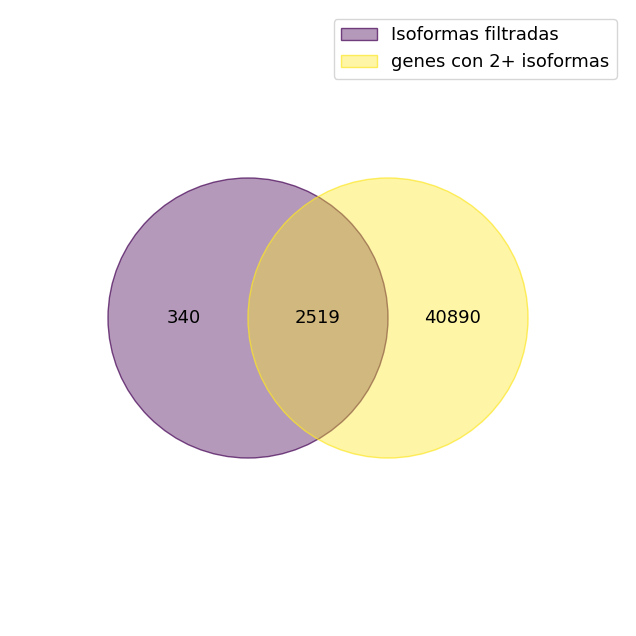

In [69]:
#VENN
groups = {
    "Isoformas filtradas": set(result3_nuc_final),
    "genes con 2+ isoformas": set(df_gene.index.get_level_values('isoform').unique().tolist())
}
venn(groups)
plt.savefig("./isoforms_of_genes_with_2_or_more_isoforms.png")

In [70]:
result_df_final = [i for i in set(result3_nuc_final) if i in set(df_gene.index.get_level_values('isoform').unique().tolist())]

In [71]:
len(result_df_final)

2519

In [72]:
filtered_candidates_ONT = ONT_nuc_cito_total.loc[ONT_nuc_cito_total.index.get_level_values('isoform').isin(result_df_final)]

In [73]:
filtered_candidates_ONT = filtered_candidates_ONT.loc[:,["Nuc L", "Nuc D"]]

In [74]:
filtered_candidates_ONT.sum(axis=1).sort_values(ascending=False).to_csv("Candidatos_ncARNm.csv")

In [75]:
search_df = filtered_candidates_ONT.sum(axis=1).sort_values(ascending=False).reset_index()

In [76]:
for gene in ['AT3G61860',"AT1G09140","AT4G36690","AT3G02300"]:
    display(search_df[search_df.gene == gene])

,gene,isoform,0
10,AT3G61860,AT3G61860_ID2,2221.341393
544,AT3G61860,AT3G61860_s1,221.875045


,gene,isoform,0
751,AT1G09140,AT1G09140_CR3,169.002667


,gene,isoform,0
25,AT4G36690,AT4G36690_P3,1553.757972
30,AT4G36690,AT4G36690_P2,1425.287577


,gene,isoform,0
129,AT3G02300,AT3G02300_ID1,587.371267
312,AT3G02300,AT3G02300_ID3,347.663594


___
## Data Normalization
For a correct filtering, a normalization between nuclear and citoplasmic fractions should be performed.
I will use the DEseq2 normalization

In [77]:
from math import inf
def DESeq2_normalization(df):
    """
    Applies DESeq2 normalization to the main DataFrame (big_df)
    """
    df_copy = df.copy(deep=True)
    df_copy = df_copy.loc[~(df_copy==0).all(axis=1)]
    log_df = np.log(df_copy)
    log_df["average"] = log_df.mean(axis=1, numeric_only=True)
    log_df_clean = log_df.drop(log_df[log_df.average == -inf].index)  # must import inf from math
    log_df_clean.iloc[:, :-1] = log_df_clean.iloc[:, :-1].subtract(log_df_clean['average'].values, axis=0)
    median = log_df_clean.iloc[:, :-1].median()
    print(median)
    scaling_factors = np.power(10, median.values)
    print("Scaling Factors")
    print(scaling_factors)
    df_copy = df_copy.multiply(scaling_factors, axis='columns')
    return df_copy  

In [78]:
new_df = DESeq2_normalization(ONT_nuc_cito)
new_df

condition  sample
Nuc L      TPM_1     0.126897
           TPM_2     0.149622
           TPM_3     0.205256
Nuc D      TPM_1    -0.047055
           TPM_2    -0.036765
           TPM_3    -0.041119
Cit L      TPM_1     0.109862
           TPM_2     0.070059
           TPM_3     0.046747
Cit D      TPM_1    -0.121378
           TPM_2    -0.097672
           TPM_3    -0.066355
dtype: float64
Scaling Factors
[1.33935885 1.41130959 1.60418924 0.89731531 0.91882997 0.90966358
 1.28784144 1.17505749 1.11364676 0.75617531 0.7985975  0.85831259]


condition                    Nuc L                               Nuc D   
sample                       TPM_1       TPM_2       TPM_3       TPM_1   
gene      isoform                                                        
AT1G01010 AT1G01010.1     2.045238   15.505693    0.000000    8.428994  \
AT1G01020 AT1G01020_P1   53.126756   50.435157   52.867330   34.716743   
          AT1G01020_P2   22.759902    8.457580    0.000000    0.000000   
          AT1G01020_P3   77.506189   86.860780  144.328643   73.174381   
          AT1G01020_P5    0.000000    0.000000    0.000000    0.000000   
...                            ...         ...         ...         ...   
ATMG01320 ATMG01320.1     0.000000    0.000000    0.000000    1.685799   
ATMG01350 ATMG01350.1     2.045238    0.000000    0.000000    0.000000   
ATMG01370 ATMG01370.1     4.090476    3.101138   13.146398    0.000000   
ATMG01380 ATMG01380.1     4.090476    9.303416    0.000000    3.371598   
ATMG01390 ATMG01390.1   291.156191  195.371734  223.488769  207.353254   

condition                                            Cit L               
sample                       TPM_2       TPM_3       TPM_1       TPM_2   
gene      isoform                                                        
AT1G01010 AT1G01010.1     5.965816    8.836790    8.554949   10.433896  \
AT1G01020 AT1G01020_P1   33.279273   29.081483   30.797815   10.433896   
          AT1G01020_P2    0.000000    0.000000    0.000000    0.000000   
          AT1G01020_P3   56.207972   90.491504    0.000000    0.000000   
          AT1G01020_P5    0.000000    4.142071    0.000000    0.000000   
...                            ...         ...         ...         ...   
ATMG01320 ATMG01320.1     0.000000    2.236160    0.000000    2.608474   
ATMG01350 ATMG01350.1     0.000000    0.000000    0.000000    0.000000   
ATMG01370 ATMG01370.1     1.193163    0.000000    6.843959    2.608474   
ATMG01380 ATMG01380.1     0.000000    2.209197    8.554949   10.433896   
ATMG01390 ATMG01390.1   194.485611  216.501354  229.272624  279.106705   

condition                                Cit D                          
sample                       TPM_3       TPM_1       TPM_2       TPM_3  
gene      isoform                                                       
AT1G01010 AT1G01010.1    10.799313    5.060839   10.843921   11.708866  
AT1G01020 AT1G01020_P1   21.598627    0.000000   10.189765    9.757389  
          AT1G01020_P2    0.000000    5.060839    0.000000    0.000000  
          AT1G01020_P3    0.000000    0.000000    9.948947    0.000000  
          AT1G01020_P5    0.000000    0.000000    0.000000    0.000000  
...                            ...         ...         ...         ...  
ATMG01320 ATMG01320.1     0.000000    1.713594    0.000000    0.000000  
ATMG01350 ATMG01350.1     0.000000    1.875240    1.549131    0.000000  
ATMG01370 ATMG01370.1     5.399657    1.686946    0.000000    0.000000  
ATMG01380 ATMG01380.1     0.000000    3.373892    1.549131    3.902955  
ATMG01390 ATMG01390.1   359.227929  521.283246  463.190362  583.491839  

[49556 rows x 12 columns]

In [79]:
ONT_nuc_cito

condition                    Nuc L                               Nuc D   
sample                       TPM_1       TPM_2       TPM_3       TPM_1   
gene      isoform                                                        
AT1G01010 AT1G01010.1     1.527028   10.986741    0.000000    9.393570  \
AT1G01020 AT1G01020_P1   39.665812   35.736423   32.955794   38.689570   
          AT1G01020_P2   16.993132    5.992718    0.000000    0.000000   
          AT1G01020_P3   57.868128   61.546227   89.969836   81.548125   
          AT1G01020_P4    0.000000    0.000000    0.000000    0.000000   
...                            ...         ...         ...         ...   
ATMG01330 ATMG01330.1     0.000000    0.000000    0.000000    0.000000   
ATMG01350 ATMG01350.1     1.527028    0.000000    0.000000    0.000000   
ATMG01370 ATMG01370.1     3.054055    2.197348    8.195042    0.000000   
ATMG01380 ATMG01380.1     3.054055    6.592045    0.000000    3.757428   
ATMG01390 ATMG01390.1   217.384752  138.432939  139.315714  231.081820   

condition                                            Cit L               
sample                       TPM_2       TPM_3       TPM_1       TPM_2   
gene      isoform                                                        
AT1G01010 AT1G01010.1     6.492840    9.714350    6.642859    8.879477  \
AT1G01020 AT1G01020_P1   36.219185   31.969493   23.914291    8.879477   
          AT1G01020_P2    0.000000    0.000000    0.000000    0.000000   
          AT1G01020_P3   61.173421   99.477990    0.000000    0.000000   
          AT1G01020_P4    0.000000    0.000000    0.000000    0.000000   
...                            ...         ...         ...         ...   
ATMG01330 ATMG01330.1     0.000000    0.000000    0.000000    0.000000   
ATMG01350 ATMG01350.1     0.000000    0.000000    0.000000    0.000000   
ATMG01370 ATMG01370.1     1.298568    0.000000    5.314287    2.219869   
ATMG01380 ATMG01380.1     0.000000    2.428587    6.642859    8.879477   
ATMG01390 ATMG01390.1   211.666595  238.001564  178.028612  237.526000   

condition                                Cit D                          
sample                       TPM_3       TPM_1       TPM_2       TPM_3  
gene      isoform                                                       
AT1G01010 AT1G01010.1     9.697252    6.692679   13.578707   13.641727  
AT1G01020 AT1G01020_P1   19.394504    0.000000   12.759575   11.368106  
          AT1G01020_P2    0.000000    6.692679    0.000000    0.000000  
          AT1G01020_P3    0.000000    0.000000   12.458024    0.000000  
          AT1G01020_P4    0.000000    0.000000    0.000000    0.000000  
...                            ...         ...         ...         ...  
ATMG01330 ATMG01330.1     0.000000    0.000000    0.000000    0.000000  
ATMG01350 ATMG01350.1     0.000000    2.479901    1.939815    0.000000  
ATMG01370 ATMG01370.1     4.848626    2.230893    0.000000    0.000000  
ATMG01380 ATMG01380.1     0.000000    4.461786    1.939815    4.547242  
ATMG01390 ATMG01390.1   322.569007  689.368248  580.004772  679.812745  

[54095 rows x 12 columns]

## New filtering

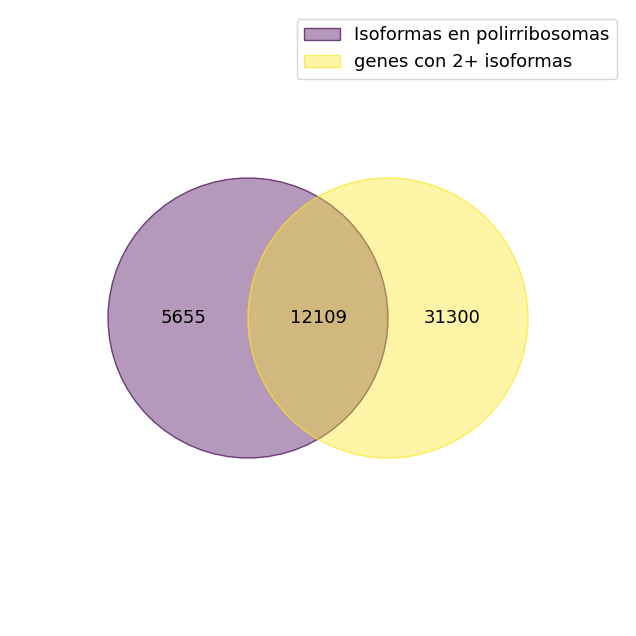

In [80]:
#VENN
groups = {
    "Isoformas en polirribosomas": set(polyribo_isoforms_set),
    "genes con 2+ isoformas": set(df_gene.index.get_level_values('isoform').unique().tolist())
}
venn(groups)
plt.savefig("./isoforms_of_translatable_genes_with_2_or_more_isoforms.png")

In [82]:
polirribo_2_mas = [i for i in set(polyribo_isoforms_set) if i in set(df_gene.index.get_level_values('isoform').unique().tolist())]

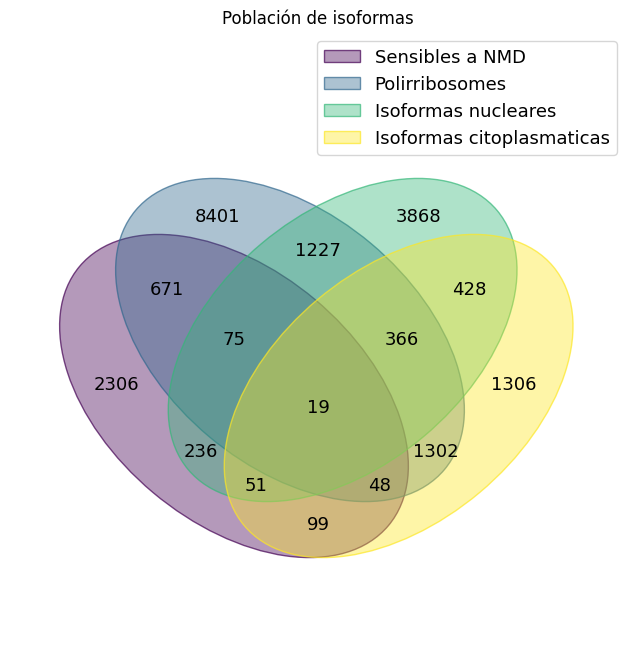

In [84]:
groups = {
    "Sensibles a NMD":NMD_isoforms_set,
    "Polirribosomes": set(polirribo_2_mas),
    "Isoformas nucleares": set(result3_nuc_total_prop),
    "Isoformas citoplasmaticas": set(result3_cit_total_prop)
}
venn(groups)
plt.title("Población de isoformas")

plt.savefig("./Isoform_populations_polirribo2mas_ONT_by_prop.png")

In [88]:
transcriptome_2_mas = transcriptome.where(transcriptome["isoform"].isin(polyribo_isoforms_set)).dropna()
transcriptome_2_mas[transcriptome_2_mas["gene"] == "AT3G61860"] # Funciona

,gene,isoform
245043,AT3G61860,AT3G61860_P1


In [89]:
genes_finales = transcriptome.where(transcriptome["isoform"].isin(result_df_final)).dropna()

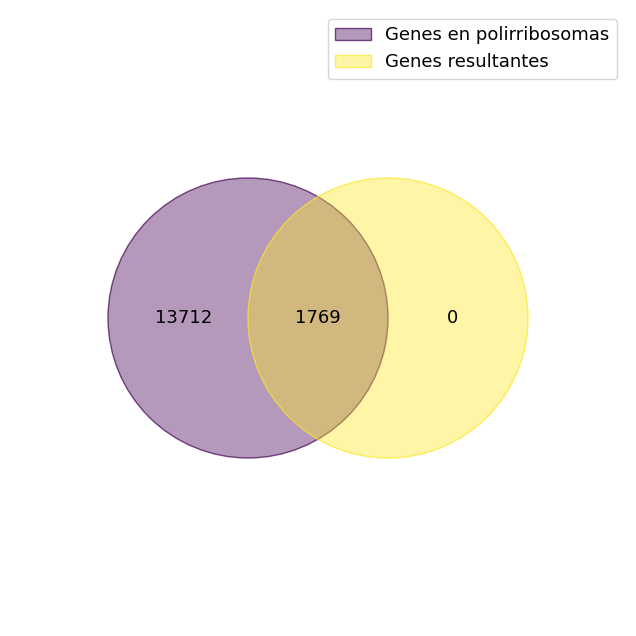

In [97]:
#VENN
groups = {
    "Genes en polirribosomas": set(transcriptome_2_mas.gene.unique().tolist()),
    "Genes resultantes": set(genes_finales.gene.unique().tolist())
}
venn(groups)
plt.savefig("./genes_of_translatable_genes_with_2_or_more_isoforms.png")

In [92]:
genes_resultantes = [i for i in set(genes_finales.gene.unique().tolist()) if i in set(transcriptome_2_mas.gene.unique().tolist())]
len(genes_resultantes)

1769

In [96]:
genes_finales = transcriptome.where(transcriptome["gene"].isin(genes_resultantes)).dropna()
genes_finales[genes_finales["gene"] == "AT4G36690"] # Funciona

,gene,isoform
303014,AT4G36690,AT4G36690.4
303027,AT4G36690,AT4G36690_ID1
303039,AT4G36690,AT4G36690_ID3
303053,AT4G36690,AT4G36690_JC2
303067,AT4G36690,AT4G36690_P1
303080,AT4G36690,AT4G36690_P2
303092,AT4G36690,AT4G36690_P3
